In [197]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

In [198]:
import seaborn as sn
import warnings
warnings.filterwarnings("ignore")

In [199]:
#NLP
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

In [200]:
from PIL import Image

In [546]:
import re
import string

In [614]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.externals import joblib
from sklearn import linear_model
import sklearn.preprocessing
import sklearn.linear_model
import sklearn.pipeline

***Data set import:***

In [553]:
"""It is not necessary to re-rerun this cells after a %reset"""

"to load assets on the server (if it was not already done)"
import os
if not os.path.exists("Dataset"):
    !git clone https://github.com/youness-elh/Dataset

"checking: directories 'dataframe','img'  must appear"
!ls Dataset

Cloning into 'Dataset'...
fatal: unable to access 'https://github.com/youness-elh/Dataset/': Failed to connect to github.com port 443: Connection refused
Der Befehl "ls" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.


# Introduction:

***Food choices and preferences of college students***

This dataset includes information on food choices, nutrition, preferences, childhood favorites, and other information from college students. There are 125 responses from students. Data is raw and uncleaned. Data comes from kaggle.
Dataset was created to take a look at student's nutrition habits:

- What does influence on students cooking frequency?
- Are students who are active in sports put more attention to nutritional check than the others?
- Are kids and parents have similar cooking habits?
- Is there any correlation between types of world cuisines that students like or do not like? 
- ...

In this notebook we will visualize some of these features and try find any connections.

The main goals:

- Data exploration/some cleaning.
- Data analysis.
- Visualization.




# Création d'un pipeline de prétraitement

Notre input X et notre output Y sont prêt pour être servi aux algos de machine learning. 

Mais nous allons enpaqueter tous les prétraitement dans un pipeline, qui sera aussi appliqué au jeu test (sauf que nous ne fiterons jamais sur test).

  

Remarque: l'emploi d'un objet (et pas d'une fonction) se justifie ici: on a besoin de stocker certaines valeurs. 

In [645]:
class MyPipeline():
        
    """this method is automaticaly called we buid the object i.e. we write pipeline=MyPipeLine() """
    def __init__(self,path_to_data,fill_with= 'median'):
        
        self.path = path_to_data
        self.fill_with = fill_with
        
        self._scaler = sklearn.preprocessing.StandardScaler()
        self._was_fit = False
        self._was_fit_strat = False
        self._was_read = False
        self._was_cleaned = False
        
        self.X_names=None
        self.df = None
        self.strat_test_set = None
        self.strat_train_set = None
        self.test_set = None
        self.train_set = None
        
        '''output'''
        self.X_train = None
        self.X_test = None
        self.Y_train = None
        self.Y_test = None
           
    def read_data(self):
        self._was_read = True
        self.df = pd.read_csv(self.path)
        self.data = self.df.copy()
        
    def clean_data(self,df,feature,feature_type,fill_with = 'median'):
    
        def remove_point(x):
            if x =='.':
                return ''
            else:
                return x
    
        if df[feature].dtype == object :
            df[feature] = df[feature].str.replace('[a-z]|[A-Z]|\,|\"|\;|\'|\s','')
            df[feature] = df[feature].apply(remove_point)
            df[feature].replace(to_replace='',value=0,inplace=True)
            #print('In "'+str(feature)+'" feature some non sens words were deleted')

        if df[feature].isnull().any():
            df[feature].fillna(0,inplace=True)
            #print('In "'+str(feature)+'" feature some nan value were replaced by the '+ str(fill_with))

        else:
            #print('"'+str(feature)+'" feature was already cleaned!')
            pass

        df[feature] = df[feature].astype(feature_type)
        mean = round(df[feature].mean(),1) if fill_with =='mean' else round(df[feature].median(),1)
        df[feature].replace(to_replace=0,value=mean,inplace=True) 

        if feature == 'weight':
             df[feature] = df[feature].apply(lambda x : round(x/2.205,3))

        return df
    
    def All_no_nlp_clean(self):
        self._was_cleaned = True
        
        if self._was_read == False:
            self.read_data()
            
        try:
            open_ended_columns = ['comfort_food','comfort_food_reasons','diet_current','eating_changes','father_profession','mother_profession','fav_cuisine','food_childhood','healthy_meal','ideal_diet','meals_dinner_friend','type_sports']
            df_no_nlp = self.df.drop(open_ended_columns,axis=1)
        except Exception:
            pass
        features = df_no_nlp.columns
        n =len(features)
        for i,f in enumerate(features):
            #print('-----'+str(i+1)+'th feature begins out of '+str(n)+' features-----')
            df_no_nlp = self.clean_data(df_no_nlp,f,'float','median')

        self.df = df_no_nlp
            
    def delete_corr_feat(self):
        try:
            self.df.drop("comfort_food_reasons_coded", axis=1, inplace=True)
        except Exception:
            pass
        
    def cleaned_nlp(self,feature = 'comfort_food'):
        open_ended_columns = ['comfort_food','comfort_food_reasons','diet_current','eating_changes','father_profession','mother_profession','fav_cuisine','food_childhood','healthy_meal','ideal_diet','meals_dinner_friend','type_sports']
        df_nlp = self.data.loc[:,open_ended_columns]
        
        def clean_text(text):
            '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
            text = text.lower()
            text = re.sub('\[.*?\]', '', text)
            text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
            text = re.sub('\w*\d\w*', '', text)
            text = re.sub('[‘’“”…]', '', text)
            text = re.sub('\n', '', text)
            return text
    
        for f in open_ended_columns:
            df_nlp[f] = pd.DataFrame(df_nlp[f].apply(lambda x: clean_text(str(x))))
            
        cv = CountVectorizer(stop_words='english')
        data_cv = cv.fit_transform(df_nlp[feature])
        data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
        data_dtm.index = df_nlp.index
        
        return df_nlp, data_dtm  
    
    def plot_top_words(self,feature = 'comfort_food'):
        df_nlp, data_dtm = self.cleaned_nlp(feature)
        
        try:
            maskComfy = 255-np.array(Image.open( "../heart.png"))
        except Exception:
            print('mask not available')
            pass

        wordcloud = (WordCloud(width=1440, height=1080, relative_scaling=0.5,
        stopwords=stopwords,mask=maskComfy,max_words=1000,background_color='white').generate_from_frequencies(df_nlp[feature].value_counts()))

        fig = plt.figure(1,figsize=(15, 15))
        plt.imshow(wordcloud,interpolation="gaussian")
        plt.axis('off')
        plt.show()
        
    
    def convert_to_cat(self):
        
        features = ['calories_chicken','calories_scone', 'tortilla_calories', 'turkey_calories','waffle_calories']
        def change_to_cat(x):
            if x == 265.0 or x == 107.0 or x == 580.0 or x == 345.0  or x == 575.0:
                x =1
            elif x == 430.0 or x == 315.0  or x == 725.0 or x == 500.0  or x == 760.0:
                x=2
            elif x == 610.0 or x == 420.0  or x == 940.0 or x == 690.0  or x == 900.0:
                x=3
            elif x == 720.0 or x == 980.0  or x == 1165.0 or x == 850.0  or x == 1315.0:
                x=4
            return int(x)

        for _,f in enumerate(features):
            self.df[f] = self.df[f].apply(change_to_cat)
            self.df[f] = self.df[f].astype('int')
        
    
    def standardize(self):
        num_columns = ['GPA','weight']
        scaler=StandardScaler()
        df_num_st=scaler.fit_transform(self.df[num_columns])
        self.df[num_columns] = pd.DataFrame(df_num_st)
        
    def x_train_test_random(self):
        if not self._was_fit:
            self.train_set, self.test_set = train_test_split(self.df, test_size=0.2, random_state=42)
        
    '''Dans notre jeu de donnée, le 'GPA' (Note) est un descripteur naturellement pour stratifier la population.''' 
    def x_train_test_strat(self, plot=False):
        
        if not self._was_fit_strat:
        
            self.df["GPA_cat"] = np.ceil(self.df["GPA"]/1.5)
            self.df["GPA_cat"].where(self.df["GPA"] < 4,4.0, inplace=True)
            split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
            for train_index, test_index in split.split(self.df, self.df["GPA_cat"]):
                self.strat_train_set = self.df.loc[train_index]
                self.strat_test_set = self.df.loc[test_index]
                
            if plot :
                freq=self.df["GPA_cat"].value_counts()
                # ou bien avec numpy
                # freq=np.unique(housing_0["income_cat"].values,return_counts=True)
                plt.bar(freq.index,freq.values);
                plt.show();

            self._was_fit_strat = True
            try:
                for set_ in (self.strat_train_set, self.strat_test_set):
                    set_.drop("GPA_cat", axis=1, inplace=True)
                    
                self.df.drop("GPA_cat", axis=1, inplace=True)
            except Exception:
                pass

        
    def input_output_numpy(self,feature_y = 'GPA',strat=True,conv_stand = True):
        
        if not self._was_read:
            self.read_data()
            #print('read')

        if not self._was_cleaned:
            self.All_no_nlp_clean()
            #print('cleaned')
         
        if conv_stand:
            '''convert to cat and standardize'''
            self.convert_to_cat()
            self.standardize()
            
        if strat == True:
            self.x_train_test_strat(False)
            self.X_test = self.strat_test_set.copy()
            self.X_train = self.strat_train_set.copy()
            
        else:
            self.x_train_test_random()
            self.X_test = self.test_set
            self.X_train = self.train_set
            
            
        self.Y_train = self.X_train[feature_y].values.reshape(-1)
        self.Y_test = self.X_test[feature_y].values.reshape(-1)
        
        self.X_train = self.X_train.drop(feature_y, axis=1, inplace=False)
        self.X_names = self.X_train.columns.values
        self.X_train = np.array(self.X_train)
        self.X_test = self.X_test.drop(feature_y, axis=1, inplace=False)
        self.X_test = np.array(self.X_test) 
        #print(self.Y_test.shape,self.X_test.shape)

In [666]:
path_to_data = '..//food_coded.csv'
fill_with = 'median'
obj = MyPipeline(path_to_data ,fill_with)

# Data preparation:

## Clean

In [667]:
obj.All_no_nlp_clean()

In [668]:
obj.df.head(2)

,GPA,Gender,breakfast,calories_chicken,calories_day,calories_scone,coffee,comfort_food_reasons_coded,cook,comfort_food_reasons_coded.1,...,self_perception_weight,soup,sports,thai_food,tortilla_calories,turkey_calories,veggies_day,vitamins,waffle_calories,weight
0,2.400,2.0,1.0,430.0,3.0,315.0,1.0,9.0,2.0,9.0,...,3.0,1.0,1.0,1.0,1165.0,345.0,5.0,1.0,1315.0,84.807
1,3.654,1.0,1.0,610.0,3.0,420.0,2.0,1.0,3.0,1.0,...,3.0,1.0,1.0,2.0,725.0,690.0,4.0,2.0,900.0,70.295


## Suppression de variables inutiles

In [669]:
obj.delete_corr_feat()

In [670]:
obj.df.head(2)

,GPA,Gender,breakfast,calories_chicken,calories_day,calories_scone,coffee,cook,comfort_food_reasons_coded.1,cuisine,...,self_perception_weight,soup,sports,thai_food,tortilla_calories,turkey_calories,veggies_day,vitamins,waffle_calories,weight
0,2.400,2.0,1.0,430.0,3.0,315.0,1.0,2.0,9.0,1.0,...,3.0,1.0,1.0,1.0,1165.0,345.0,5.0,1.0,1315.0,84.807
1,3.654,1.0,1.0,610.0,3.0,420.0,2.0,3.0,1.0,1.0,...,3.0,1.0,1.0,2.0,725.0,690.0,4.0,2.0,900.0,70.295


## Natural Language Processing

Le résultat de cet étape sera des données propres et organisées dans deux formats de texte standard :
* Corpus - un recueil de textes
* comptage des mots sous forme de matrice


In [671]:
df_nlp,df_dtm = obj.cleaned_nlp()

***Corpus:***

In [672]:
df_nlp.head(2)

,comfort_food,comfort_food_reasons,diet_current,eating_changes,father_profession,mother_profession,fav_cuisine,food_childhood,healthy_meal,ideal_diet,meals_dinner_friend,type_sports
0,none,we dont have comfort,eat good and exercise,eat faster,profesor,unemployed,arabic cuisine,rice and chicken,looks not oily,being healthy,rice chicken soup,car racing
1,chocolate chips ice cream,stress bored anger,i eat about three times a day with some snacks...,i eat out more than usual,self employed,nurse rn,italian,chicken and biscuits beef soup baked beans,grains veggies more of grains and veggies smal...,try to eat small meals a day while trying to ...,pasta steak chicken,basketball


***Document-Term Matrix:***

Pour bon nombre des techniques que nous utiliserons, le texte doit être 'tokenized', c'est-à-dire décomposé en petits morceaux. La technique de tokenisation la plus courante consiste à décomposer le texte en mots. Nous pouvons le faire en utilisant le CountVectorizer de Scikit-learn, où chaque ligne représentera un document différent et chaque colonne un mot différent.

De plus, avec CountVectorizer, nous pouvons supprimer les mots vides. Les mots d'arrêt sont des mots courants qui n'ajoutent aucune signification supplémentaire au texte, tels que "a", "le", etc.

In [673]:
df_dtm.head(2)

,almonds,bagels,banana,bar,bars,beef,bread,breadcrackers,broccoli,brownie,...,tomato,truffles,tuna,twizzlers,vinegar,watermelon,wegmans,wine,wings,yogurt
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


***Top comfort food:***

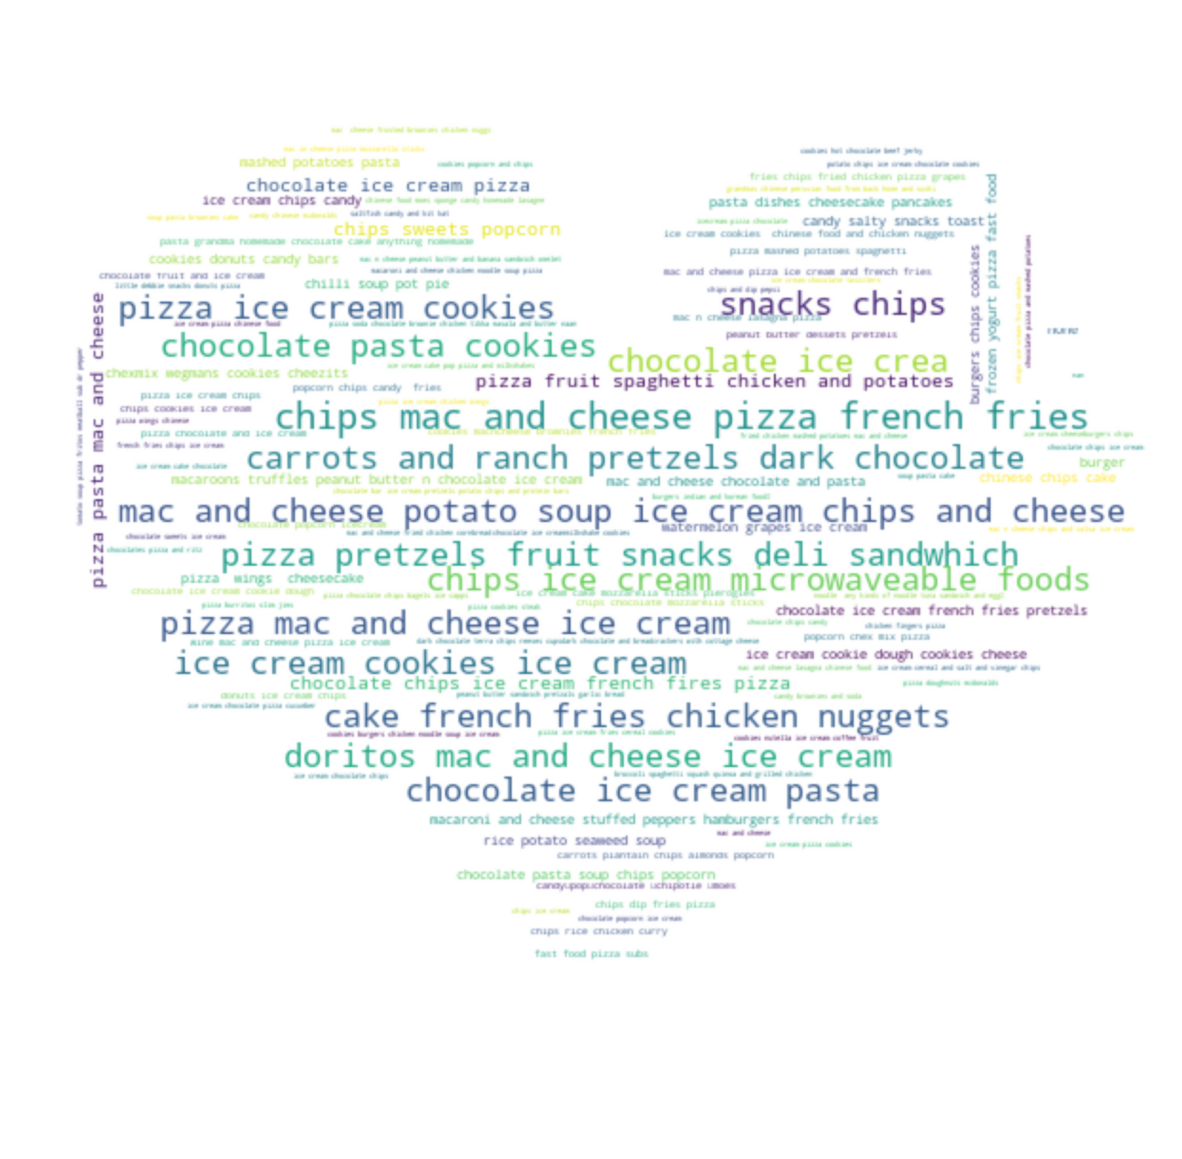

In [674]:
obj.plot_top_words('comfort_food')

## Convert to categories

In [675]:
obj.df['calories_chicken'].head(5)

0    430.0
1    610.0
2    720.0
3    430.0
4    720.0
Name: calories_chicken, dtype: float64

In [676]:
obj.convert_to_cat()

In [677]:
obj.df['calories_chicken'].head(3)

0    2
1    3
2    4
Name: calories_chicken, dtype: int32

In [678]:
data = obj.df.copy()
num_columns = ['GPA','weight']

In [679]:
df_cat= data.drop(num_columns,axis=1,inplace=False)

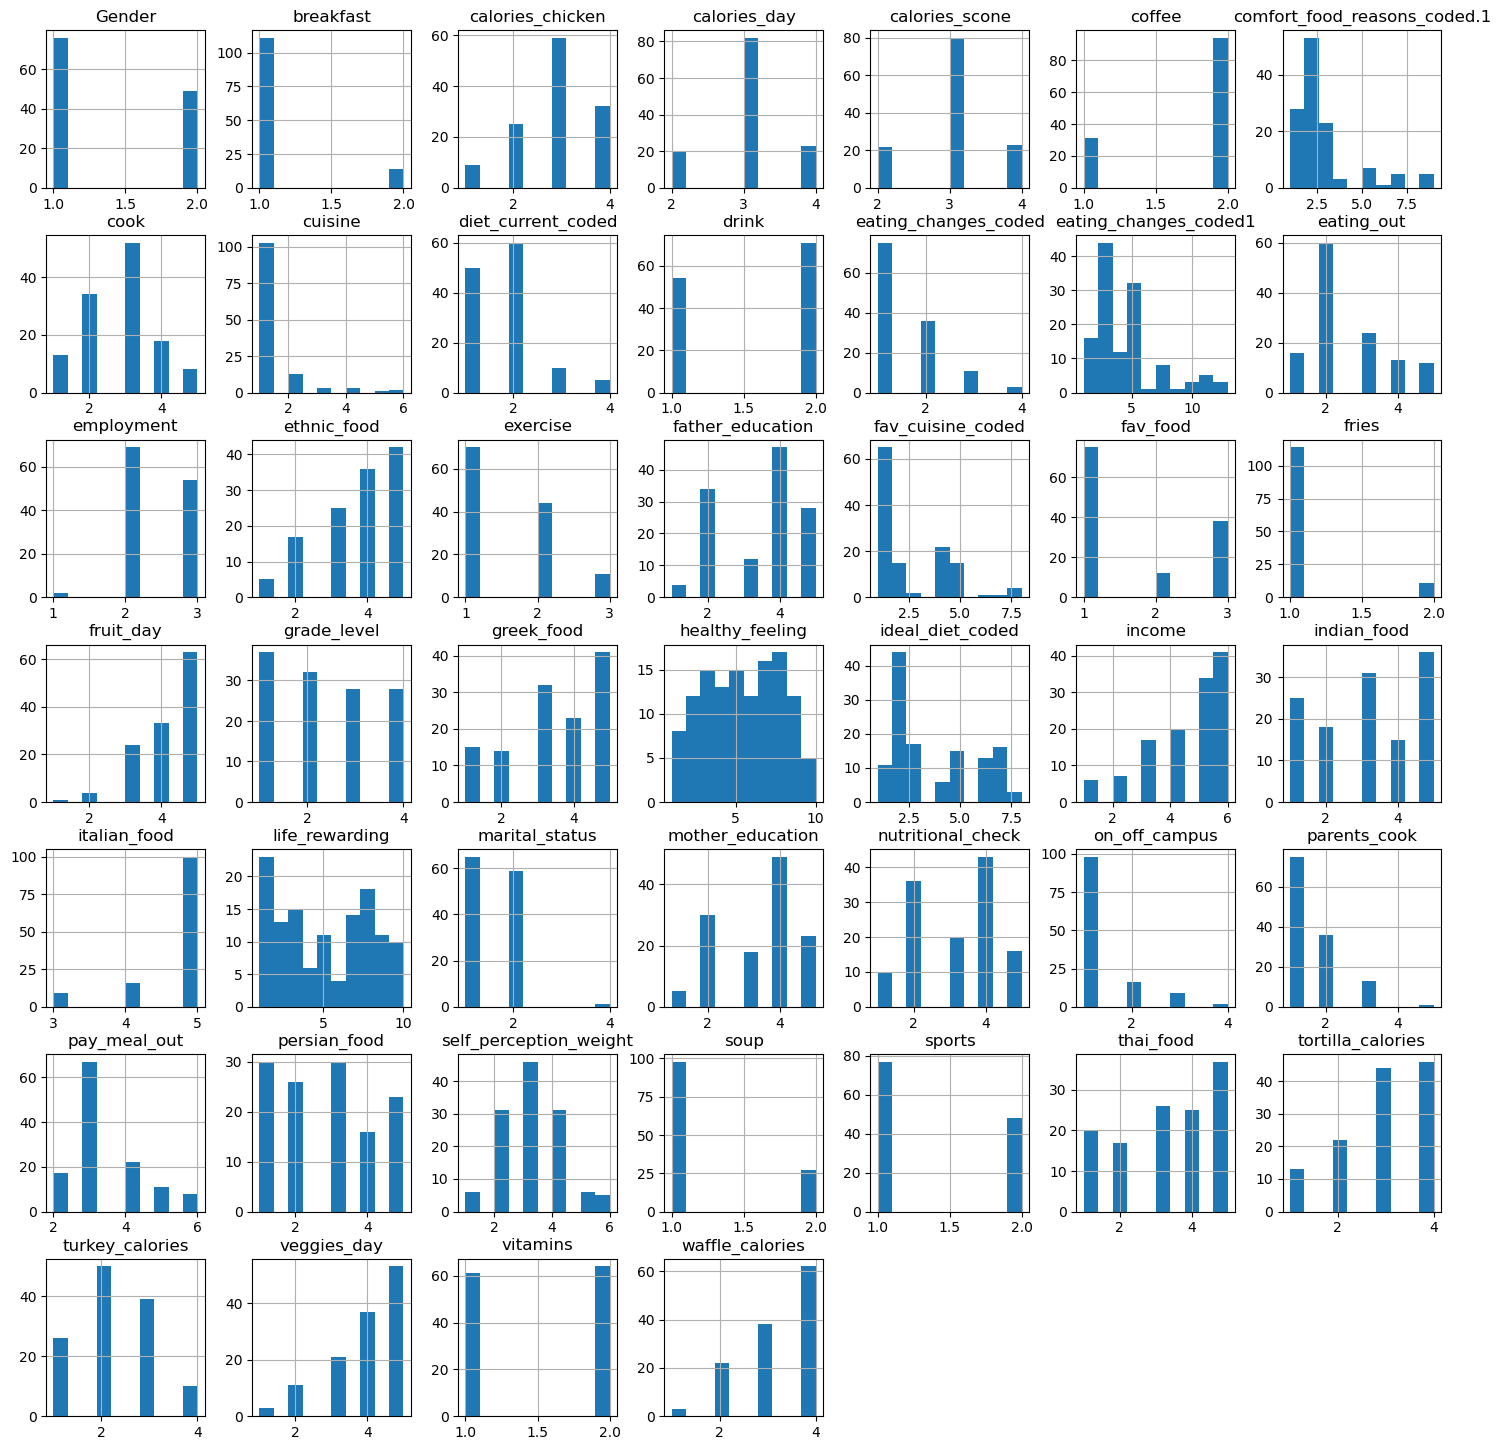

In [680]:
df_cat.hist(bins=10, figsize=(18,18));

## Varibales continues

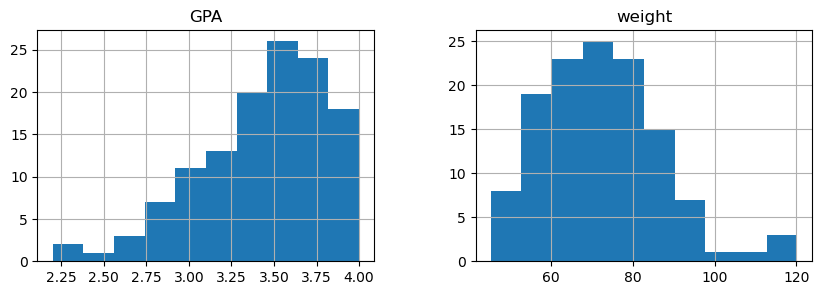

In [681]:
num_columns = ['GPA','weight']
df_num = data[num_columns]
df_num.hist(bins=10, figsize=(10,3));

In [682]:
df_num.describe()

,GPA,weight
count,125.000000,125.000000
mean,3.421256,72.087072
std,0.383926,14.507365
min,2.200000,45.351000
25%,3.200000,61.224000
50%,3.500000,70.295000
75%,3.700000,81.633000
max,4.000000,120.181000


### Centrer et réduire 

La méthode de scaling la plus classique est la standardisation: on soustrait à chaque variable numérique sa moyenne puis on divise par l'écart-type.

Il est habituel de 'fiter' le scaler sur les données train uniquement: on calcule moyennes et les écarts-types sur train. Ensuite on centre-réduit train et test avec ces moyennes et écart types.

L'autre solution serait de centrer-réduire train et test indépendamment avec leur propre moyennes et écart-type. Mais il faut imaginer que les données test peuvent arriver à posteriori et être très petites (ex: 2 lignes). Cela n'a pas de sens de calculer une moyenne et un écart type dessus.

Cependant cette règle peu connaitre des exceptions. Par exemple: les jeux de données arrivent par paquets, et proviennent d'appareils dont le qualibrage change avec le temps. Dans ce cas, il est naturel de centrer-réduire systèmatiquement les paquets de données. 

In [683]:
obj.standardize()
data_stand = obj.df.copy()

In [684]:
num_columns = ['GPA','weight']
data_stand[num_columns].describe()

,GPA,weight
count,1.250000e+02,1.250000e+02
mean,-1.847411e-16,-4.085621e-16
std,1.004024e+00,1.004024e+00
min,-3.193770e+00,-1.850347e+00
25%,-5.786181e-01,-7.518103e-01
50%,2.059276e-01,-1.240255e-01
75%,7.289580e-01,6.606535e-01
max,1.513504e+00,3.328479e+00


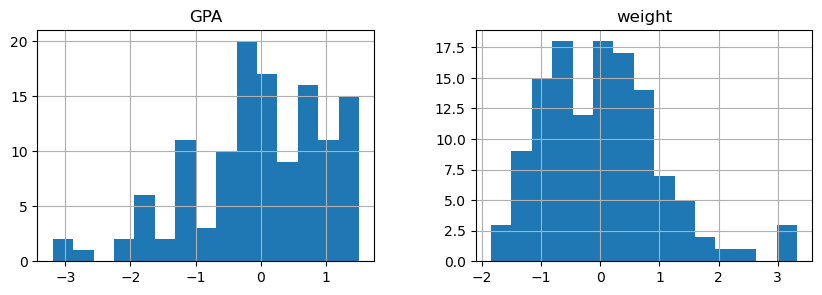

In [685]:
df_num = data_stand[num_columns]
df_num.hist(bins=15, figsize=(10,3));

##  Preparation de train_set et test_set:

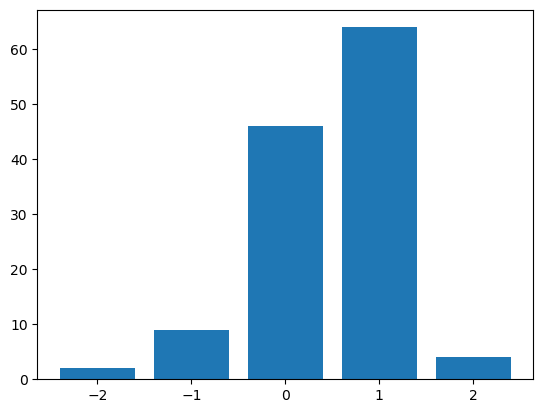

In [686]:
obj.x_train_test_strat(True)

In [687]:
obj.strat_train_set.head(3)

,GPA,Gender,breakfast,calories_chicken,calories_day,calories_scone,coffee,cook,comfort_food_reasons_coded.1,cuisine,...,self_perception_weight,soup,sports,thai_food,tortilla_calories,turkey_calories,veggies_day,vitamins,waffle_calories,weight
44,-0.578618,1.0,1.0,3,4.0,3,2.0,1.0,1.0,1.0,...,3.0,1.0,1.0,5.0,2,2,5.0,1.0,2,0.346796
52,-0.317103,2.0,1.0,3,4.0,3,2.0,1.0,2.0,1.0,...,2.0,2.0,1.0,3.0,4,2,5.0,2.0,3,1.288369
88,0.205928,2.0,2.0,4,4.0,4,2.0,3.0,9.0,1.0,...,2.0,1.0,2.0,5.0,4,4,4.0,1.0,4,0.503690


In [688]:
obj.strat_test_set.head(3)

,GPA,Gender,breakfast,calories_chicken,calories_day,calories_scone,coffee,cook,comfort_food_reasons_coded.1,cuisine,...,self_perception_weight,soup,sports,thai_food,tortilla_calories,turkey_calories,veggies_day,vitamins,waffle_calories,weight
90,0.676655,2.0,1.0,4,4.0,3,2.0,4.0,2.0,1.0,...,4.0,2.0,1.0,3.0,4,4,4.0,1.0,4,3.171585
38,1.225837,1.0,1.0,3,3.0,4,2.0,3.0,2.0,1.0,...,4.0,1.0,1.0,2.0,4,3,3.0,2.0,4,-0.280989
95,0.205928,2.0,1.0,1,3.0,3,2.0,3.0,2.0,1.0,...,2.0,2.0,1.0,4.0,4,3,4.0,2.0,4,0.786197


## Création de : X_train,X_test et Y_train,Y_test.

In [689]:
path_to_data = '..//food_coded.csv'
fill_with = 'median'
obj = MyPipeline(path_to_data ,fill_with)

In [690]:
obj.input_output_numpy()

X_train,Y_train=obj.X_train,obj.Y_train
X_test,Y_test=obj.X_test,obj.Y_test
X_names=obj.X_names

In [691]:
""" we check that MyPipeline.input_output_numpy() make the same job as our exploratory job."""
print('--------X_test-------- \n',X_test[:5,:10])
print('--------X_train-------- \n',X_train[:5,:10])
print("X_names\n",X_names[:10])

--------X_test-------- 
 [[2. 1. 4. 4. 3. 2. 2. 4. 2. 1.]
 [1. 1. 3. 3. 4. 2. 2. 3. 2. 1.]
 [2. 1. 1. 3. 3. 2. 2. 3. 2. 1.]
 [1. 1. 3. 3. 2. 2. 2. 2. 2. 2.]
 [1. 1. 4. 3. 3. 1. 3. 2. 3. 1.]]
--------X_train-------- 
 [[1. 1. 3. 4. 3. 2. 1. 1. 1. 1.]
 [2. 1. 3. 4. 3. 2. 2. 1. 2. 1.]
 [2. 2. 4. 4. 4. 2. 9. 3. 9. 1.]
 [2. 1. 2. 3. 2. 2. 5. 3. 5. 2.]
 [2. 1. 3. 3. 2. 1. 2. 3. 2. 3.]]
X_names
 ['Gender' 'breakfast' 'calories_chicken' 'calories_day' 'calories_scone'
 'coffee' 'comfort_food_reasons_coded' 'cook'
 'comfort_food_reasons_coded.1' 'cuisine']


***Remarque:***
Attention, dans les objets de sklearn, il ne faut rentrer que des matrices numpy. Si on  rentre une dataframe pandas, l'index sera utilisé comme un descripteur!!! 

Par contre, on peut utiliser pandas à posteriori pour présenter les résultats:

# Sélectionnons et entrainons un modèle

Ici commence le machine-learning. Commençons par l'algo le plus simple. 


## Modèle linéaire

In [692]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, Y_train)
Y_train_hat=lin_reg.predict(X_train);

In [693]:
def present_result(nb=100):
    df=pd.DataFrame({
        "Y_train_hat":Y_train_hat[:nb],
        "Y_train":Y_train[:nb]
    })
    return df

out = present_result()

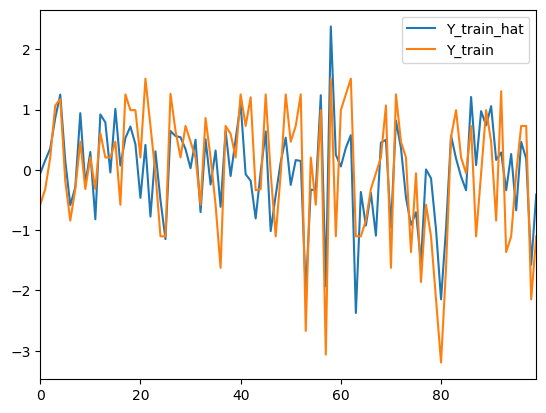

In [694]:
out.plot();

### Estimation de l'erreur

In [695]:
def show_metrics():
    """mean square error"""
    mse = mean_squared_error(Y_train, Y_train_hat)
    """root mean square error"""
    rmse = np.sqrt(mse)
    """mean absolute error """
    mae = mean_absolute_error(Y_train, Y_train_hat)

    print("lin_rmse:",rmse)
    print("lin_mae:",mae)
    
show_metrics()

lin_rmse: 0.6776166216218297
lin_mae: 0.5759650954608246


Le modéle linéaire ne semble pas satisfaisant mais il va falloir le valider et le comparer à d'autres modèles.

### Validation croisée

On découpe le jeu train en 10 parties, appelée feuille (=fold). Puis on entraine et évalue le modèle 10 fois, en prenant à chaque fois une feuille différente pour l'évaluation, et les 9 autres pour l'entrainement.  

In [696]:
losses = -cross_val_score(lin_reg, X_train, Y_train,scoring="neg_mean_absolute_error", cv=10)
print("regression lineaire, CV WITH SKLEARN")
print("mean score:",np.mean(losses))
print("sdt score:",np.std(losses))

regression lineaire, CV WITH SKLEARN
mean score: 1.2075307237366775
sdt score: 0.34433961226678594


### Persistance:

In [697]:
""" the file my_model.pkl contain the description of the model, and all its parameters and hyperparameters. """
joblib.dump(lin_reg, "my_model_linear.pkl") 
""" and one week later: """
best_model_one_week_later = joblib.load("my_model_linear.pkl") 
best_model_one_week_later.predict(X_test)

array([ 3.81113887e-01, -6.55524105e-01, -9.22807381e-01, -2.02349043e-02,
        1.79441989e-01,  6.76395812e-01, -2.59384160e+00,  1.30946249e+00,
        3.24526238e-01, -1.67389246e+00, -1.58085085e+00, -2.52862445e-01,
       -1.16394091e+00,  7.84893036e-01, -1.89143874e-03, -3.01320903e+00,
       -2.41013254e+00,  9.13017796e-02,  1.49356123e+00, -1.63593547e+00,
       -1.30540678e+00, -2.65159668e+00,  8.78672148e-01, -7.25933959e-01,
        5.08635563e-01])

## Decision Tree

In [698]:
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(X_train, Y_train)
Y_train_hat=tree_reg.predict(X_train)

out = present_result()

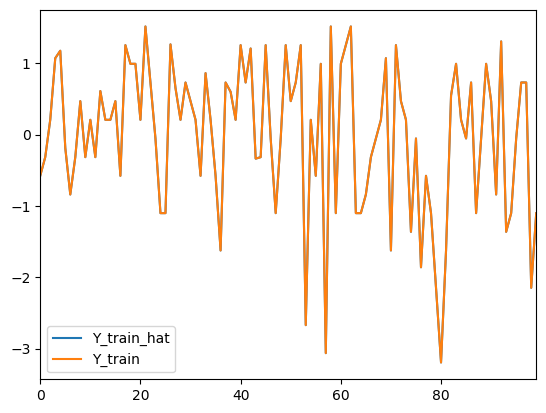

In [699]:
out.plot();

### Estimation de l'erreur

In [571]:
show_metrics()

lin_rmse: 4.955361418800576e-18
lin_mae: 1.0408340855860842e-18


Le modèle semble parfait en attendant la validation.

Le modèle a overfitter les données train. Il nous faudrait un autre moyen pour évaluer l'erreur. Et il est encore trop tot pour utiliser le jeu test (on l'utilisera qu'une fois que l'on aura choisi le modèle et ses hyper-paramètres). 

On a donc deux technique pour valider notre modèle: 

* La validation simple: au tout début on sépare les données en train/validation/test et on validera sur le jeu 'validation'. 
* la validation croisée ...

### Validation croisée

On découpe le jeu train en 10 parties, appelée feuille (=fold). Puis on entraine et évalue le modèle 10 fois, en prenant à chaque fois une feuille différente pour l'évaluation, et les 9 autres pour l'entrainement.  

In [656]:
losses = -cross_val_score(tree_reg, X_train, Y_train,scoring="neg_mean_absolute_error", cv=10)
print("DECISSION TREE, CV WITH SKLEARN")
print("mean score:",np.mean(losses))
print("sdt score:",np.std(losses))

DECISSION TREE, CV WITH SKLEARN
mean score: 1.3977466222228572
sdt score: 0.269423061441082


### Persistance:

In [665]:
""" the file my_model.pkl contain the description of the model, and all its parameters and hyperparameters. """
joblib.dump(tree_reg, "my_model_tree.pkl") 
""" and one week later: """
best_model_one_week_later = joblib.load("my_model_tree.pkl") 
best_model_one_week_later.predict(X_test)

array([-2.14770955,  0.65050345,  1.06892783, -0.57861815,  0.20592756,
        0.65050345, -0.31710291,  1.25198849,  1.25198849,  1.2624491 ,
        0.20592756,  1.25198849, -1.36316385,  0.99047326, -1.36316385,
       -1.10164861,  0.20592756,  1.25198849, -0.05558768, -0.31710291,
       -0.31710291,  0.46744279,  0.99047326,  1.2624491 ,  1.25198849])

### Random forest 

La forêt aléatoire est un ensemble d'arbre de décisions entrainé sur des sous-ensembles différents de descripteurs. On moyenne ensuite les prédictions de chacun des arbre pour obtenir la prédiction de la forêt.


In [591]:
forest_reg = RandomForestRegressor(random_state=42,n_estimators=6,max_features=48)
forest_reg.fit(X_train, Y_train)
Y_train_hat=tree_reg.predict(X_train)

out = present_result()

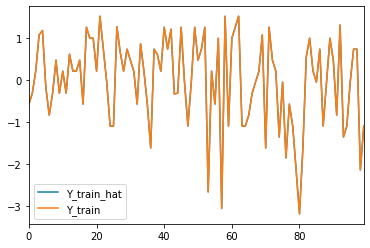

In [590]:
out.plot();

### Validation croisée

On découpe le jeu train en 10 parties, appelée feuille (=fold). Puis on entraine et évalue le modèle 10 fois, en prenant à chaque fois une feuille différente pour l'évaluation, et les 9 autres pour l'entrainement.  

In [592]:
losses = -cross_val_score(forest_reg, X_train, Y_train,scoring="neg_mean_absolute_error", cv=10)
print("DECISSION TREE, CV WITH SKLEARN")
print("mean score:",np.mean(losses))
print("sdt score:",np.std(losses))

DECISSION TREE, CV WITH SKLEARN
mean score: 0.9050257700057329
sdt score: 0.19644639742248812


### Ajustons les hyper-paramètres (Fine-Tuning)

Les hyper-paramètres d'une forêt aléatoire sont: 

* `max_features`
* `bootstrap`
* `n_estimators`

#### Recherche aléatoire

##### Les avantages de la recherche aléatoire
 

* on peut interompre ou reprendre à tout moment une recherche aléatoire. Alors qu'en intérompant une recherche en grille, on laisse des intervalles de valeur inexplorés. 

* on a beaucoup  de souplesse dans le choix des hyper-paramètre: on n'est pas obligé de les tirer de manière uniforme: On peut insister sur les valeurs qui nous paraissent les meilleures. On peut facilement ajouter  des  contrainres (tel hyper-paramètre doit être plus petit que tel autre ...)

* On peut travailler avec un grand nombre d'hyper-paramètre et un grand nombre de valeur. Dans ce cas, une recherche exhaustive serait trop couteur. 

* La recherche aléatoire a aussi un avantage caché: supposons qu'un premier paramètre a très peu d'importance (ils influe très peu les performances) et qu'un second paramètre a beaucoup d'influence. Bien entendu, cette information nous ait cachée (sinon on ne ferait varier que le second paramètre).  Avec la recherche aléatoire, on va explorer beaucoup de valeurs différentes du second paramètre, donc on aura plus de chande de tomber sur une valeur optimale. 


In [596]:
results=[]

In [598]:
""" vous pouvez arrêter et relancer cette cellule autant de fois que vous voulez """
try:
    for i in range(10):

        bootstrap=np.random.choice([True,False],p=[0.7,0.3]) 
        n_estimators=np.random.randint(5,30)
        max_features=np.random.randint(2,9) #doit être inférieur au nombre de feature (=descripteur)

        print("on teste: bootstrap:",bootstrap,", n_estimators:",n_estimators,", max_features",max_features)

        
        forest_reg = RandomForestRegressor(
            random_state=42,
            bootstrap=bootstrap,
            n_estimators=n_estimators,
            max_features=max_features
        )
        
        losses = -cross_val_score(forest_reg, X_train, Y_train,scoring="neg_mean_absolute_error", cv=10)
        scores_rmse=np.mean(losses)
        
        results.append({
            "bias": np.round(np.mean(scores_rmse)),
            "std" : np.round(np.std(scores_rmse)),
            "bootstrap":bootstrap,
            "n_estimators":n_estimators,
            "max_features":max_features
        })
except KeyboardInterrupt:
    print("on a intérompu la recherche")

on teste: bootstrap: True , n_estimators: 5 , max_features 8
on teste: bootstrap: False , n_estimators: 7 , max_features 2
on teste: bootstrap: False , n_estimators: 22 , max_features 7
on teste: bootstrap: True , n_estimators: 14 , max_features 3
on teste: bootstrap: True , n_estimators: 25 , max_features 8
on teste: bootstrap: True , n_estimators: 17 , max_features 7
on teste: bootstrap: True , n_estimators: 25 , max_features 6
on teste: bootstrap: True , n_estimators: 5 , max_features 5
on teste: bootstrap: False , n_estimators: 9 , max_features 7
on teste: bootstrap: False , n_estimators: 6 , max_features 7


In [599]:
results.sort(key=lambda elem: elem["bias"])
# ou bien 
# results_sorted=sorted(results,key=lambda elem: elem["bias"])
pd.DataFrame(results[:10])

,bias,std,bootstrap,n_estimators,max_features
0,1.0,0.0,True,5,8
1,1.0,0.0,False,7,2
2,1.0,0.0,False,22,7
3,1.0,0.0,True,14,3
4,1.0,0.0,True,25,8
5,1.0,0.0,True,17,7
6,1.0,0.0,True,25,6
7,1.0,0.0,True,5,5
8,1.0,0.0,False,9,7
9,1.0,0.0,False,6,7


***Analysons le meilleur modèle:***

On gagne beaucoup en inspectant notre meilleurs modèle. Notamment, les random forest peuvent indiquer quelles sont les descripteurs qui ont le plus d'influence sur la cible. 

In [600]:
best_params=results[0]
best_params

{'bias': 1.0,
 'std': 0.0,
 'bootstrap': True,
 'n_estimators': 5,
 'max_features': 8}

In [601]:
best_model= RandomForestRegressor(
                random_state=42,
                bootstrap=best_params["bootstrap"],
                n_estimators=best_params["n_estimators"],
                max_features=best_params["max_features"]
            )
best_model.fit(X_train,Y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=8, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=None,
                      oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

***Les descripteurs les plus importants pour le modèle:***

In [605]:
feature_importances=best_model.feature_importances_
named_feature_importances=[]
for i in range(len(feature_importances)):
    named_feature_importances.append((X_names[i],feature_importances[i]))
named_feature_importances.sort(key=lambda pair:-pair[1])
named_feature_importances[:5]

[('weight', 0.08567170886880483),
 ('mother_education', 0.07081261884840734),
 ('nutritional_check', 0.05495226423936228),
 ('ethnic_food', 0.05319877917475546),
 ('thai_food', 0.05290245028070142)]

## Evaluons le modèle sur les données test   

In [609]:
Y_test_hat=best_model.predict(X_test)

In [610]:
def present_result(nb=100):
    df=pd.DataFrame({
        "Y_train_hat":Y_test_hat[:nb],
        "Y_train":Y_test[:nb]
    })
    return df

out = present_result()

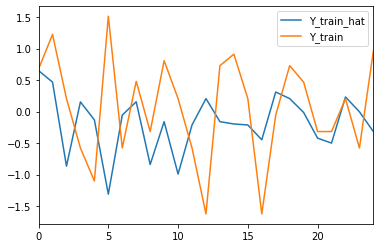

In [612]:
out.plot();

In [613]:
mae_test=np.mean(np.abs(Y_test-Y_test_hat))
squared_errors=(Y_test-Y_test_hat)**2

mse_test=np.mean(squared_errors)
rmse_test=np.sqrt(np.mean((Y_test-Y_test_hat)**2))
print("mae_test:",mae_test)
print("rmse_test:",rmse_test)

mae_test: 0.7700054547360016
rmse_test: 0.9782647386756467


#----------------------------------------------------------------------------#

###  Persistence

Maintenant, il faut sauverager son travail.  

In [648]:
""" the file my_model.pkl contain the description of the model, and all its parameters and hyperparameters. """
joblib.dump(best_model, "my_model_forest.pkl") 
""" and one week later: """
best_model_one_week_later = joblib.load("my_model_forest.pkl") 
best_model_one_week_later.predict(X_test)

array([ 0.65050345,  0.46744279, -0.8662849 ,  0.15362451, -0.13195013,
       -1.3108608 , -0.05558768,  0.15571663, -0.84013338, -0.16019377,
       -0.99181222, -0.21249682,  0.20592756, -0.16019377, -0.1968059 ,
       -0.21249682, -0.44786053,  0.31053365,  0.20592756, -0.01374524,
       -0.42170901, -0.50016358,  0.23207908, -0.00328463, -0.31710291])

#----------------------------------------------------------------------------#

# Exploration:

## Read data:

In [622]:
%pwd

'C:\\Users\\elh\\Desktop\\data\\Resolution'

In [623]:
data = pd.read_csv('..//food_coded.csv')
data.shape

(125, 61)

In [624]:
data.head(1)

,GPA,Gender,breakfast,calories_chicken,calories_day,calories_scone,coffee,comfort_food,comfort_food_reasons,comfort_food_reasons_coded,...,soup,sports,thai_food,tortilla_calories,turkey_calories,type_sports,veggies_day,vitamins,waffle_calories,weight
0,2.4,2,1,430,NaN,315.0,1,none,we dont have comfort,9.0,...,1.0,1.0,1,1165.0,345,car racing,5,1,1315,187


## Clean

In [625]:
def Clean(df,feature,feature_type,fill_with ='median'):
    
    def remove_point(x):
        if x =='.':
            return ''
        else:
            return x
    
    if df[feature].dtype == object :
        df[feature] = df[feature].str.replace('[a-z]|[A-Z]|\,|\"|\;|\'|\s','')
        df[feature] = df[feature].apply(remove_point)
        df[feature].replace(to_replace='',value=0,inplace=True)
        #print('In "'+str(feature)+'" feature some non sens words were deleted')
        
    if df[feature].isnull().any():
        df[feature].fillna(0,inplace=True)
        #print('In "'+str(feature)+'" feature some nan value were replaced by the '+ str(fill_with))
    
    else:
        #print('"'+str(feature)+'" feature was already cleaned!')
        pass
        
    df[feature] = df[feature].astype(feature_type)
    mean = round(df[feature].mean(),1) if fill_with =='mean' else round(df[feature].median(),1)
    df[feature].replace(to_replace=0,value=mean,inplace=True) 
    
    if feature == 'weight':
         df[feature] = df[feature].apply(lambda x : round(x/2.205,3))
        
    
    return df

In [626]:
def All_no_nlp_clean(data):
    open_ended_columns = ['comfort_food','comfort_food_reasons','diet_current','eating_changes','father_profession','mother_profession','fav_cuisine','food_childhood','healthy_meal','ideal_diet','meals_dinner_friend','type_sports']
    df_no_nlp = data.drop(open_ended_columns,axis=1)
    features = df_no_nlp.columns
    n =len(features)
    for i,f in enumerate(features):
        #print('-----'+str(i+1)+'th feature begins out of '+str(n)+' features-----')
        df_no_nlp = Clean(df_no_nlp,f,'float','median')
        
    return df_no_nlp

In [627]:
df = All_no_nlp_clean(data)



Let's make weight's distribution for each gender. To do this we can use seaborn's module. We have to drop missing values manually, because distplot function does not offer built-in parameter. Pandas dropna function returns a copy so it will not affect on our dataset.


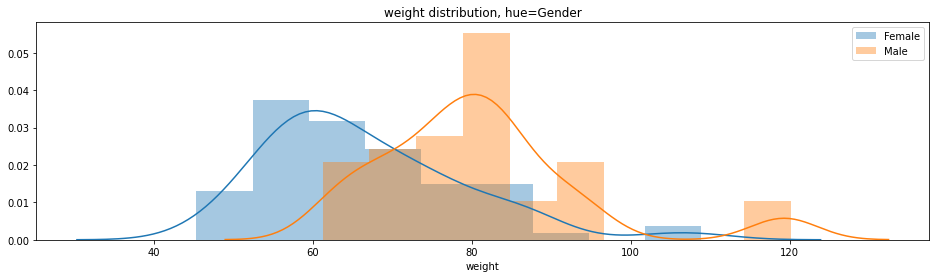

In [628]:
# Dict contains mean values of weights for both genders
weight_mean = {}
# Dict contains std values of weights for both genders
weight_std = {}

# Set plot size
fig, ax = plt.subplots(figsize=[16,4])

# Create two distributions for both genders
for gen, frame in df[['Gender', 'weight']].groupby('Gender'):
    weight_mean[gen] = frame['weight'].values.mean()
    weight_std[gen] = frame['weight'].values.std()
    sex_dict = {1: 0, 2: 1}
    sn.distplot(frame['weight'], ax=ax, label=['Female', 'Male'][sex_dict[gen]])

ax.set_title('weight distribution, hue=Gender')
ax.legend()

In [629]:
weight_mean

{1.0: 66.45780263157893, 2.0: 80.81818367346939}

# Binary features

Plot represents distribution of dichotomous variables. In this dataset 1 is binary 0 (blue colour) and 2 is binary 1 (red colour). We can notice that some of features are imbalanced. If we decide to feed them into classifier without any preprocessing, it might result in worse predictions. In this scenario, classifiers are more sensitive to detecting the majority class and less sensitive to the minority class. In many cases model will be predicting the majority class of target input.

In [630]:
# Slice binary features and their values amount without NaNs
x = df.describe().T
y = pd.Series(x[x['max'] == 2]['count'], index=x[x['max'] == 2].index)

# Percent values of 0/1 for each feature
zero_list = []
one_list = []

# Convert into percentages
for ind, col in y.iteritems():
    zero_list.append(((df[ind]==1).sum()*100)/col)
    one_list.append(((df[ind]==2).sum()*100)/col)


<Figure size 432x288 with 0 Axes>

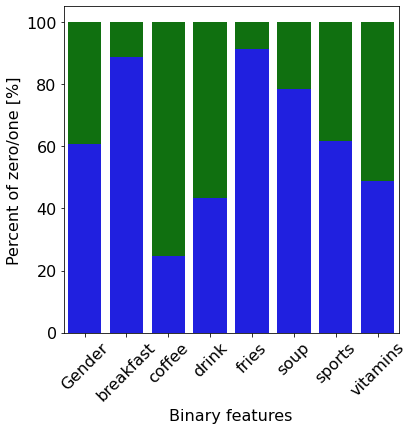

In [631]:
# Plot preparation
plt.figure()
fig, ax = plt.subplots(figsize=(6,6))

# Create barplots
sn.barplot(ax=ax, x=x[x['max'] == 2].index, y=zero_list, color="blue")
sn.barplot(ax=ax, x=x[x['max'] == 2].index, y=one_list, bottom= zero_list, color="green")

# Plot labels
plt.ylabel('Percent of zero/one [%]', fontsize=16)
plt.xlabel('Binary features', fontsize=16)

# Plot's font settings
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.tick_params(axis='both', which='major', labelsize=16)

### Importance of nutrition:

In [643]:
#the importance of calories per day
calories = data['calories_day'].value_counts()
print(calories)

3.0    63
4.0    23
2.0    20
Name: calories_day, dtype: int64


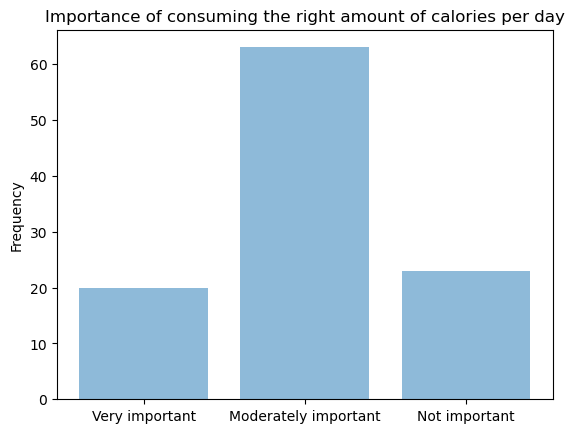

In [644]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
 
objects = ('Very important', 'Moderately important', 'Not important')
y_pos = np.arange(len(objects))
performance = calories.sort_index(axis = 0).values
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Frequency')
plt.title('Importance of consuming the right amount of calories per day')
 
plt.show()

### How offen do you cook?

In [641]:
#last one for this kernel. how often do these 18-22 year olds cook?
cook = df['cook'].value_counts()
print(cook)

3.0    52
2.0    34
4.0    18
1.0    13
5.0     8
Name: cook, dtype: int64


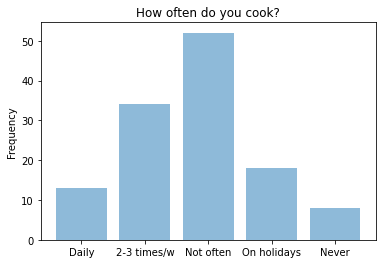

In [642]:
objects = ('Daily', '2-3 times/w', 'Not often', 'On holidays', 'Never')
y_pos = np.arange(len(objects))
performance = cook.sort_index(axis = 0).values
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Frequency')
plt.title('How often do you cook?')
 
plt.show()

## Observons la structure des données

In [793]:
df.describe()

,GPA,Gender,breakfast,calories_chicken,calories_day,calories_scone,coffee,comfort_food_reasons_coded,cook,comfort_food_reasons_coded.1,...,self_perception_weight,soup,sports,thai_food,tortilla_calories,turkey_calories,veggies_day,vitamins,waffle_calories,weight
count,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000,125.00000,125.000000,125.000000,125.000000,...,125.000000,125.00000,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000
mean,3.421256,1.392000,1.112000,577.320000,3.024000,504.560000,1.75200,2.592000,2.792000,2.688000,...,3.120000,1.21600,1.384000,3.336000,947.520000,555.040000,4.008000,1.512000,1073.400000,72.087072
std,0.383926,0.490161,0.316636,131.214156,0.588382,230.034198,0.43359,1.832045,1.026236,1.910987,...,1.111523,0.41317,0.488315,1.436528,201.274792,152.370379,1.081337,0.501867,248.667092,14.507365
min,2.200000,1.000000,1.000000,265.000000,2.000000,315.000000,1.00000,1.000000,1.000000,1.000000,...,1.000000,1.00000,1.000000,1.000000,580.000000,345.000000,1.000000,1.000000,575.000000,45.351000
25%,3.200000,1.000000,1.000000,430.000000,3.000000,420.000000,2.00000,2.000000,2.000000,2.000000,...,2.000000,1.00000,1.000000,2.000000,725.000000,500.000000,3.000000,1.000000,900.000000,61.224000
50%,3.500000,1.000000,1.000000,610.000000,3.000000,420.000000,2.00000,2.000000,3.000000,2.000000,...,3.000000,1.00000,1.000000,3.000000,940.000000,500.000000,4.000000,2.000000,900.000000,70.295000
75%,3.700000,2.000000,1.000000,720.000000,3.000000,420.000000,2.00000,3.000000,3.000000,3.000000,...,4.000000,1.00000,2.000000,5.000000,1165.000000,690.000000,5.000000,2.000000,1315.000000,81.633000
max,4.000000,2.000000,2.000000,720.000000,4.000000,980.000000,2.00000,9.000000,5.000000,9.000000,...,6.000000,2.00000,2.000000,5.000000,1165.000000,850.000000,5.000000,2.000000,1315.000000,120.181000


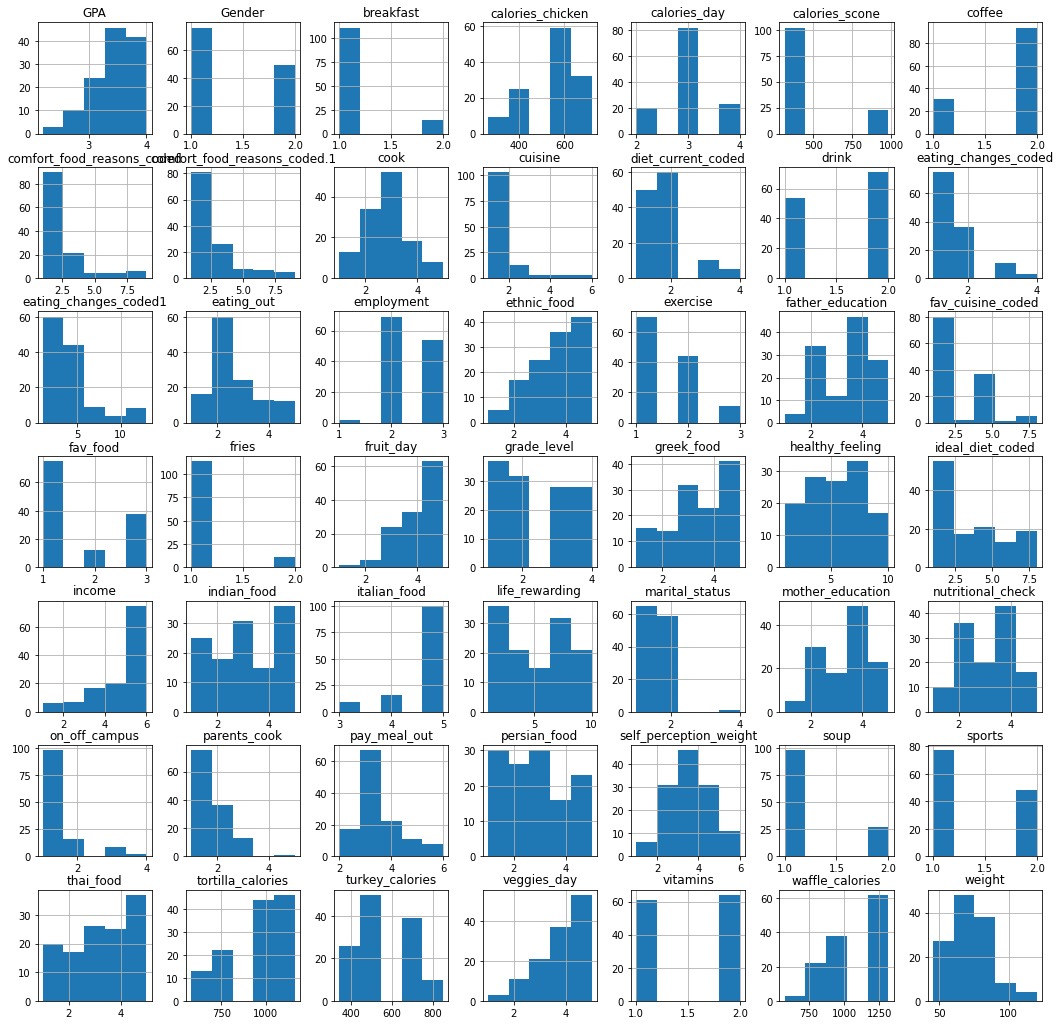

In [794]:
df.hist(bins=5, figsize=(18,18));

## Création d'un jeu de donnée "test"

Pour être vraiment honnête, il faut extraire les données test avant toute observation. Car, à la simple observation d'histogramme, un cerveau de datascientist est capable de sélectionner un modèle ou un prétraitrement particulier (on appelle cela le "data snooping bias"). 

***Premier choix: Random sampling***

In [795]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

In [796]:
train_set.describe().head(1)

,GPA,Gender,breakfast,calories_chicken,calories_day,calories_scone,coffee,comfort_food_reasons_coded,cook,comfort_food_reasons_coded.1,...,self_perception_weight,soup,sports,thai_food,tortilla_calories,turkey_calories,veggies_day,vitamins,waffle_calories,weight
count,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0


### Meilleur choix: échantillonnage stratifié (Stratified sampling) 

On divise la population en sous-groupes homogènes (=les strates), puis on va piocher dans chacun des sous-groupes pour remplir les jeux train et test. On obtiendra ainsi deux jeux plus représentatif de la population globale. 

Dans notre jeu de donnée, le 'GPA' (Note) est un descripteur naturellement pour stratifier la population. 


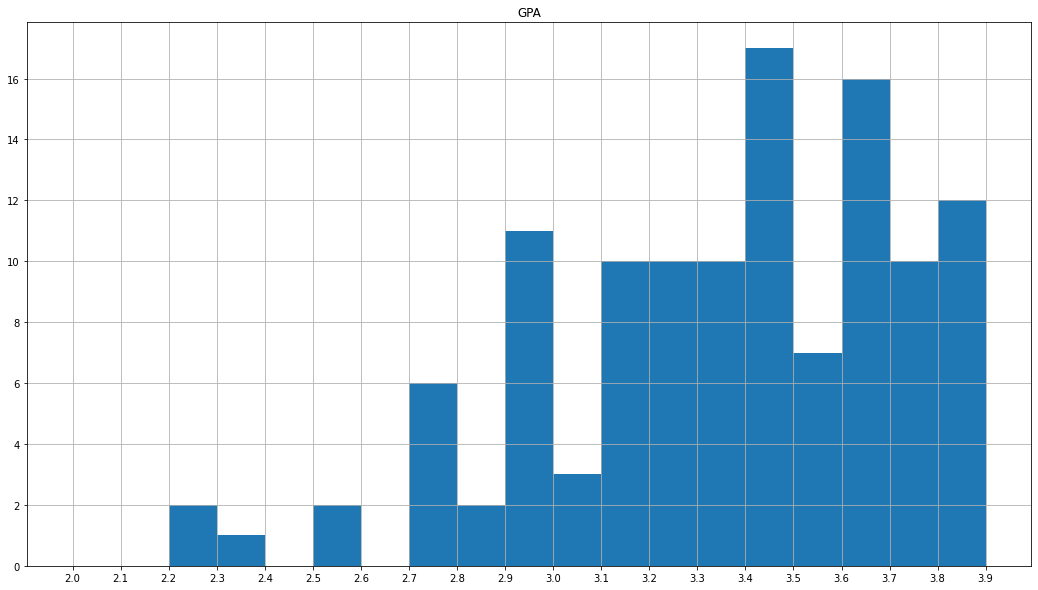

In [797]:
"""ici on améliore la méthode par défaut: df["weight"].hist()"""
data=df["GPA"].values
fig,ax=plt.subplots(1,1,figsize=(18,10))
bins=np.arange(2,np.max(data),0.1)
ax.hist(data,bins=bins)
ax.set_xticks(bins)
ax.set_title("GPA")
ax.grid(True);

Il faut créer des strates d'effectif assez grand, pour que le tirage aléatoire à l'intérieur de chaque classe n'engendre pas du "bruit d'échantillonage". 

***On va diviser les données en 3 stats selon la note des étudiant.***

In [798]:
df["GPA"].describe()

count    125.000000
mean       3.421256
std        0.383926
min        2.200000
25%        3.200000
50%        3.500000
75%        3.700000
max        4.000000
Name: GPA, dtype: float64

In [799]:
dfs = df.copy()

In [800]:
dfs["GPA_cat"] = np.ceil(dfs["GPA"]/1.5)
dfs["GPA_cat"].where(dfs["GPA"] < 4,4.0, inplace=True)

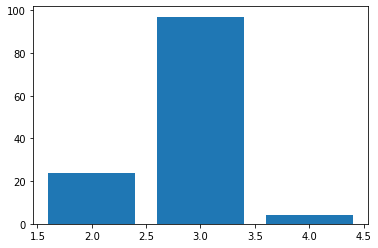

In [801]:
freq=dfs["GPA_cat"].value_counts()
# ou bien avec numpy
# freq=np.unique(housing_0["income_cat"].values,return_counts=True)
plt.bar(freq.index,freq.values);

In [802]:
dfs["GPA_cat"].describe()

count    125.000000
mean       2.840000
std        0.447214
min        2.000000
25%        3.000000
50%        3.000000
75%        3.000000
max        4.000000
Name: GPA_cat, dtype: float64

In [803]:
""" stratified sampling using sklearn"""
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(dfs, dfs["GPA_cat"]):
    strat_train_set =dfs.loc[train_index]
    strat_test_set = dfs.loc[test_index]

In [804]:
strat_test_set["GPA_cat"].value_counts() / len(strat_test_set)

3.0    0.76
2.0    0.20
4.0    0.04
Name: GPA_cat, dtype: float64

In [805]:
dfs["GPA_cat"].value_counts() / len(dfs)

3.0    0.776
2.0    0.192
4.0    0.032
Name: GPA_cat, dtype: float64

In [806]:
"we do not need 'GPA_cat' anymore "
for set_ in (strat_train_set, strat_test_set):
    set_.drop("GPA_cat", axis=1, inplace=True)

## On garde ces deux jeu de données pour l'entrainement en dessous. ( Section: Sélectionnons et entrainons un modèle)

#----------------------------------------------------------------------#
#----------------------------------------------------------------------#

In [917]:
"""we keep going with the strafied version.
We make copy, so we can come back to this point."""
df_train_stratified = strat_train_set.copy()
df_test_stratified = strat_test_set.copy()

#----------------------------------------------------------------------#
#----------------------------------------------------------------------#

***Visualisation:***

In [918]:
df_train_stratified.head(2)

,GPA,Gender,breakfast,calories_chicken,calories_day,calories_scone,coffee,comfort_food_reasons_coded,cook,comfort_food_reasons_coded.1,...,self_perception_weight,soup,sports,thai_food,tortilla_calories,turkey_calories,veggies_day,vitamins,waffle_calories,weight
33,2.8,1.0,1.0,720.0,3.0,420.0,1.0,2.0,4.0,2.0,...,3.0,1.0,2.0,1.0,1165.0,500.0,3.0,1.0,900.0,58.050
100,3.5,1.0,1.0,610.0,3.0,420.0,2.0,3.0,3.0,3.0,...,2.0,1.0,1.0,5.0,940.0,500.0,5.0,2.0,900.0,56.689


In [919]:
df_test_stratified.head(2)

,GPA,Gender,breakfast,calories_chicken,calories_day,calories_scone,coffee,comfort_food_reasons_coded,cook,comfort_food_reasons_coded.1,...,self_perception_weight,soup,sports,thai_food,tortilla_calories,turkey_calories,veggies_day,vitamins,waffle_calories,weight
116,3.4,1.0,1.0,610.0,3.0,420.0,2.0,2.0,3.0,2.0,...,4.0,1.0,2.0,5.0,725.0,345.0,5.0,1.0,1315.0,77.098
17,3.6,2.0,1.0,430.0,3.0,980.0,2.0,2.0,3.0,2.0,...,2.0,1.0,1.0,3.0,940.0,500.0,4.0,2.0,900.0,77.098


## Interaction entre variables de nutrition

In [808]:
df.keys()

Index(['GPA', 'Gender', 'breakfast', 'calories_chicken', 'calories_day',
       'calories_scone', 'coffee', 'comfort_food_reasons_coded', 'cook',
       'comfort_food_reasons_coded.1', 'cuisine', 'diet_current_coded',
       'drink', 'eating_changes_coded', 'eating_changes_coded1', 'eating_out',
       'employment', 'ethnic_food', 'exercise', 'father_education',
       'fav_cuisine_coded', 'fav_food', 'fries', 'fruit_day', 'grade_level',
       'greek_food', 'healthy_feeling', 'ideal_diet_coded', 'income',
       'indian_food', 'italian_food', 'life_rewarding', 'marital_status',
       'mother_education', 'nutritional_check', 'on_off_campus',
       'parents_cook', 'pay_meal_out', 'persian_food',
       'self_perception_weight', 'soup', 'sports', 'thai_food',
       'tortilla_calories', 'turkey_calories', 'veggies_day', 'vitamins',
       'waffle_calories', 'weight'],
      dtype='object')

In [809]:
corr_matrix=df[['calories_chicken','breakfast','calories_day','calories_scone','comfort_food_reasons_coded','comfort_food_reasons_coded.1','cook']].corr()

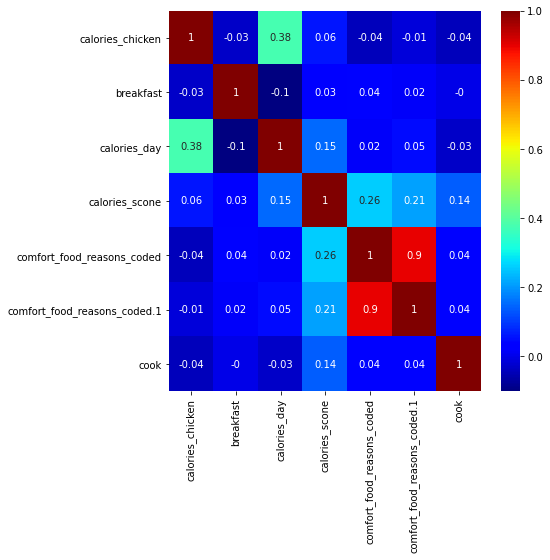

In [810]:
import seaborn as sns
plt.figure(1,figsize=(7,7))
sns.heatmap(np.round(corr_matrix,2), annot=True,cmap="jet");

***Commentaire:***
    
On a une forte correlation entre:

* `comfort_food_reasons_coded`, et

* `comfort_food_reasons_coded.1`. 

Aprés vérification sur les données sources on remarque une redondance de ces deux colonnes. On supprime la premiere car elle lui manque des données.

### Suppression de variables inutiles

In [811]:
df.drop("comfort_food_reasons_coded", axis=1, inplace=True)
dfs.drop("comfort_food_reasons_coded", axis=1, inplace=True)
dfs.drop("GPA_cat", axis=1, inplace=True)

In [812]:
df.keys()

Index(['GPA', 'Gender', 'breakfast', 'calories_chicken', 'calories_day',
       'calories_scone', 'coffee', 'cook', 'comfort_food_reasons_coded.1',
       'cuisine', 'diet_current_coded', 'drink', 'eating_changes_coded',
       'eating_changes_coded1', 'eating_out', 'employment', 'ethnic_food',
       'exercise', 'father_education', 'fav_cuisine_coded', 'fav_food',
       'fries', 'fruit_day', 'grade_level', 'greek_food', 'healthy_feeling',
       'ideal_diet_coded', 'income', 'indian_food', 'italian_food',
       'life_rewarding', 'marital_status', 'mother_education',
       'nutritional_check', 'on_off_campus', 'parents_cook', 'pay_meal_out',
       'persian_food', 'self_perception_weight', 'soup', 'sports', 'thai_food',
       'tortilla_calories', 'turkey_calories', 'veggies_day', 'vitamins',
       'waffle_calories', 'weight'],
      dtype='object')

###  Separation categorical/numérical, NLP

Nous créons trois sous dataframe:
* NLP ou `Natural language processing` (questions ouvertes)
* les categories
* Numériques

### NLP variables: 

In [882]:
data = pd.read_csv('..//food_coded.csv')

In [883]:
open_ended_columns = ['comfort_food','comfort_food_reasons','diet_current','eating_changes','father_profession','mother_profession','fav_cuisine','food_childhood','healthy_meal','ideal_diet','meals_dinner_friend','type_sports']
df_nlp = data.loc[:,open_ended_columns]

In [884]:
df_nlp.head(2)

,comfort_food,comfort_food_reasons,diet_current,eating_changes,father_profession,mother_profession,fav_cuisine,food_childhood,healthy_meal,ideal_diet,meals_dinner_friend,type_sports
0,none,we dont have comfort,eat good and exercise,eat faster,profesor,unemployed,Arabic cuisine,rice and chicken,looks not oily,being healthy,"rice, chicken, soup",car racing
1,"chocolate, chips, ice cream","Stress, bored, anger",I eat about three times a day with some snacks...,I eat out more than usual.,Self employed,Nurse RN,Italian,"chicken and biscuits, beef soup, baked beans","Grains, Veggies, (more of grains and veggies),...",Try to eat 5-6 small meals a day. While trying...,"Pasta, steak, chicken",Basketball


* Mettre le texte en minuscules
* Supprimer la ponctuation
* Supprimer les valeurs numériques

In [877]:
# Apply a first round of text cleaning techniques
import re
import string

def clean_text(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('[‘’“”…]', '', text)
    text = re.sub('\n', '', text)
    return text

In [878]:
def cleaned_nlp(df_nlp,features):
    for f in features:
        df_nlp[f] = pd.DataFrame(df_nlp[f].apply(lambda x: clean_text(str(x))))
    return df_nlp

In [887]:
df_nlp_clean = cleaned_nlp(df_nlp,open_ended_columns)

In [888]:
df_nlp_clean.head(2)

,comfort_food,comfort_food_reasons,diet_current,eating_changes,father_profession,mother_profession,fav_cuisine,food_childhood,healthy_meal,ideal_diet,meals_dinner_friend,type_sports
0,none,we dont have comfort,eat good and exercise,eat faster,profesor,unemployed,arabic cuisine,rice and chicken,looks not oily,being healthy,rice chicken soup,car racing
1,chocolate chips ice cream,stress bored anger,i eat about three times a day with some snacks...,i eat out more than usual,self employed,nurse rn,italian,chicken and biscuits beef soup baked beans,grains veggies more of grains and veggies smal...,try to eat small meals a day while trying to ...,pasta steak chicken,basketball


***Document-Term Matrix:***

Pour bon nombre des techniques que nous utiliserons, le texte doit être 'tokenized', c'est-à-dire décomposé en petits morceaux. La technique de tokenisation la plus courante consiste à décomposer le texte en mots. Nous pouvons le faire en utilisant le CountVectorizer de Scikit-learn, où chaque ligne représentera un document différent et chaque colonne un mot différent.

De plus, avec CountVectorizer, nous pouvons supprimer les mots vides. Les mots d'arrêt sont des mots courants qui n'ajoutent aucune signification supplémentaire au texte, tels que "a", "le", etc.

In [893]:
# We are going to create a document-term matrix using CountVectorizer, and exclude common English stop words

cv = CountVectorizer(stop_words='english')
data_cv = cv.fit_transform(df_nlp_clean['comfort_food'])
data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data_dtm.index = df_nlp_clean.index
data_dtm.head(2)

,almonds,bagels,banana,bar,bars,beef,bread,breadcrackers,broccoli,brownie,...,tomato,truffles,tuna,twizzlers,vinegar,watermelon,wegmans,wine,wings,yogurt
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Top comfort food?

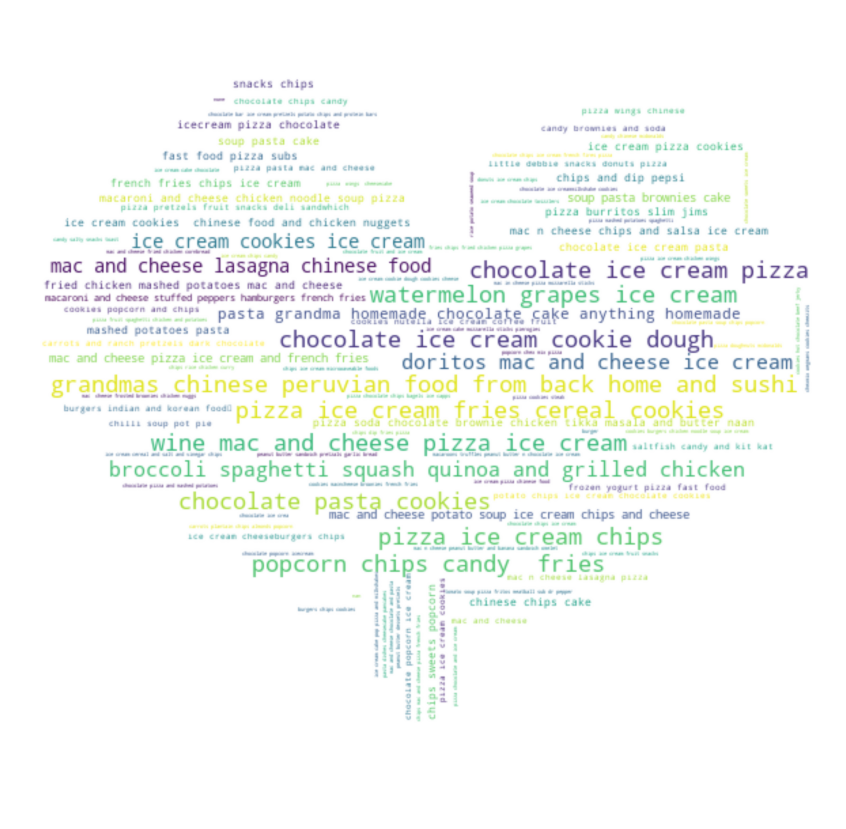

In [895]:
maskComfy = 255-np.array(Image.open( "../heart.png"))

wordcloud = (WordCloud(width=1440, height=1080, relative_scaling=0.5,
stopwords=stopwords,mask=maskComfy,max_words=1000,background_color='white').generate_from_frequencies(df_nlp_clean['comfort_food'].value_counts()))

fig = plt.figure(1,figsize=(15, 15))
plt.imshow(wordcloud,interpolation="gaussian")
plt.axis('off')
plt.show()

***Numérique***

In [815]:
num_columns = ['GPA','calories_chicken','calories_scone', 'tortilla_calories', 'turkey_calories','waffle_calories', 'weight']
df_num = df.loc[:,num_columns]

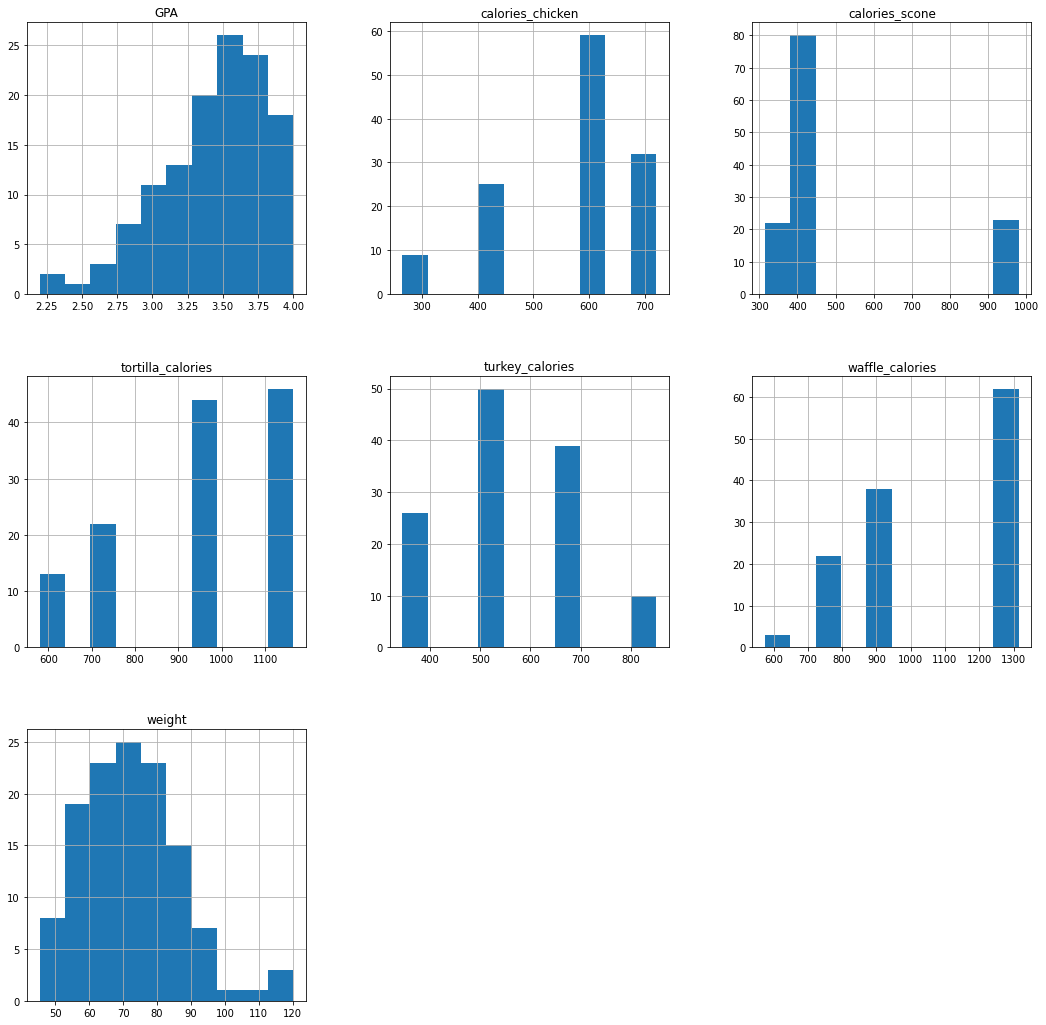

In [816]:
df_num.hist(bins=10, figsize=(18,18));

***Commentaire:***

***Il faut convertir l'uns de ces variables en variables catégoriques.***

In [817]:
def to_categories(df,features):
    def change_to_cat(x):
        if x == 265.0 or x == 107.0 or x == 580.0 or x == 345.0  or x == 575.0:
            x =1
        elif x == 430.0 or x == 315.0  or x == 725.0 or x == 500.0  or x == 760.0:
            x=2
        elif x == 610.0 or x == 420.0  or x == 940.0 or x == 690.0  or x == 900.0:
            x=3
        elif x == 720.0 or x == 980.0  or x == 1165.0 or x == 850.0  or x == 1315.0:
            x=4
        return int(x)

    for _,f in enumerate(features):
        df[f] = df[f].apply(change_to_cat)
        df[f] = df[f].astype('int')

    return df


### Convert to categories

In [821]:
features = ['calories_chicken','calories_scone', 'tortilla_calories', 'turkey_calories','waffle_calories']
df = to_categories(df,features)

***Variables Numériques:***

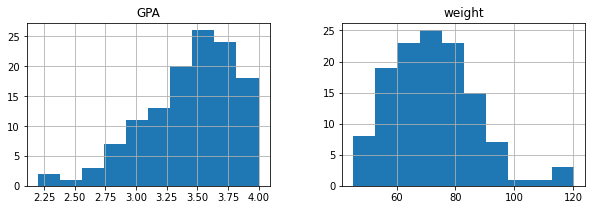

In [822]:
num_columns = ['GPA','weight']
df_num = df[num_columns]
df_num.hist(bins=10, figsize=(10,3));

***Variables catégoriques:***

In [823]:
df_cat= df.drop(num_columns,axis=1,inplace=False)

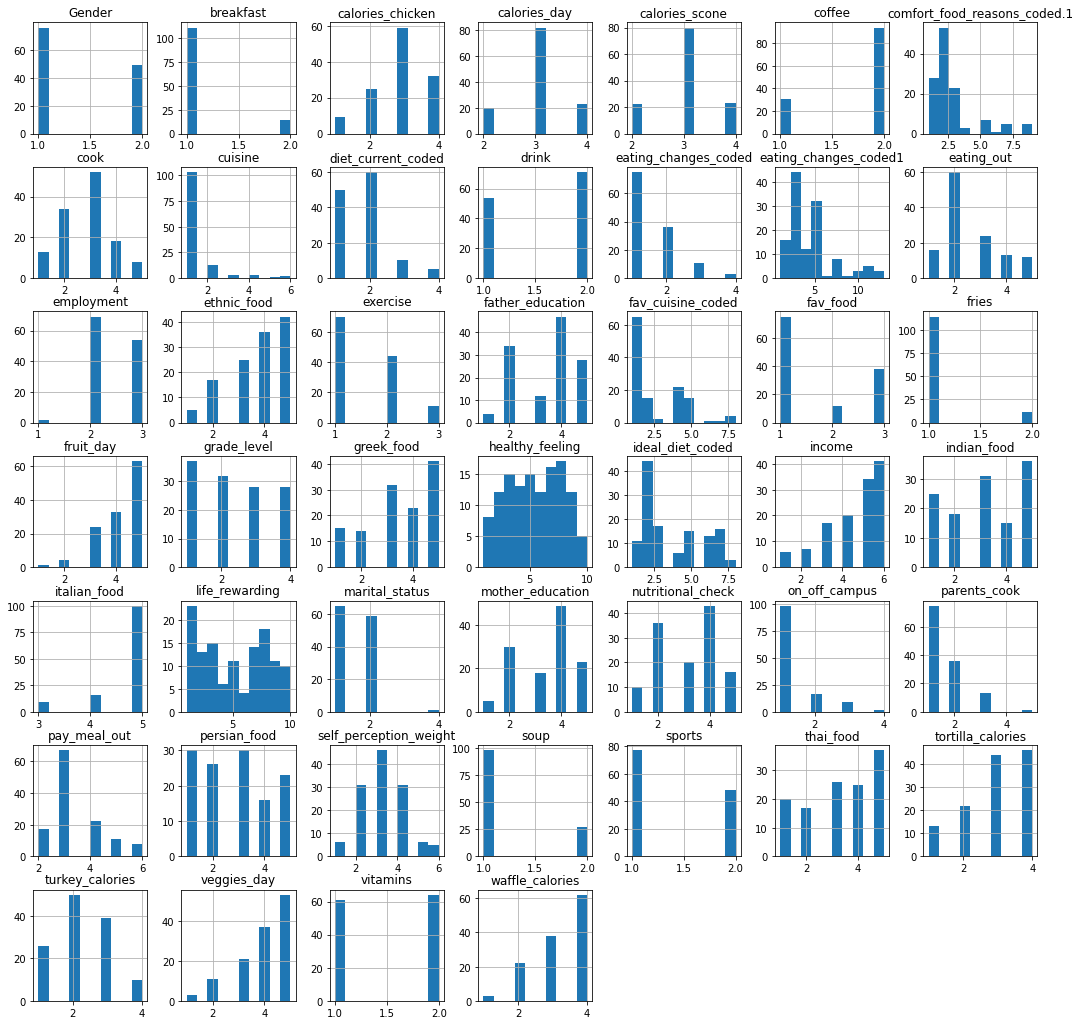

In [824]:
df_cat.hist(bins=10, figsize=(18,18));

### Standardiser (=centrer-réduire)

 

La méthode de scaling la plus classique est la standardisation: on soustrait à chaque variable numérique sa moyenne puis on  divise par l'écart-type. 

Il est habituel de 'fiter' le scaler sur les données train uniquement: on calcule moyennes et les écarts-types sur train. Ensuite on centre-réduit train et test avec ces moyennes et écart types. 


L'autre solution serait de centrer-réduire train et test indépendamment avec leur propre moyennes et écart-type. Mais il faut imaginer que les données test peuvent arriver à posteriori et être très petites (ex: 2 lignes). Cela n'a pas de sens de calculer une moyenne et un écart type dessus.  


Cependant cette règle peu connaitre des exceptions. Par exemple: les jeux de données arrivent par paquets, et proviennent d'appareils dont le qualibrage change avec le temps. Dans ce cas, il est naturel de centrer-réduire systèmatiquement les paquets de données. 


In [902]:
df_num.describe()

,GPA,weight
count,125.000000,125.000000
mean,3.421256,72.087072
std,0.383926,14.507365
min,2.200000,45.351000
25%,3.200000,61.224000
50%,3.500000,70.295000
75%,3.700000,81.633000
max,4.000000,120.181000


In [904]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
df_num_st=scaler.fit_transform(df_num)
print("df_num_st.shape:",df_num_st.shape)

df_num_st.shape: (125, 2)


Après standardisation:

In [900]:
print(np.round(np.mean(df_num_st,axis=0),3))
print(np.std(df_num_st,axis=0))

[-0. -0.]
[1. 1.]


### Union de tous les inputs

In [913]:
'''output'''
Y=df_num_st[:,0]
print("Y.shape",Y.shape)

X=np.concatenate([df_num_st[:,1:2],df_cat],axis=1)
print("X.shape:",X.shape)

X_names=np.concatenate([['weight'],df_cat.columns.values])
print("X_name\n",X_names)

Y.shape (125,)
X.shape: (125, 47)
X_name
 ['weight' 'Gender' 'breakfast' 'calories_chicken' 'calories_day'
 'calories_scone' 'coffee' 'cook' 'comfort_food_reasons_coded.1' 'cuisine'
 'diet_current_coded' 'drink' 'eating_changes_coded'
 'eating_changes_coded1' 'eating_out' 'employment' 'ethnic_food'
 'exercise' 'father_education' 'fav_cuisine_coded' 'fav_food' 'fries'
 'fruit_day' 'grade_level' 'greek_food' 'healthy_feeling'
 'ideal_diet_coded' 'income' 'indian_food' 'italian_food' 'life_rewarding'
 'marital_status' 'mother_education' 'nutritional_check' 'on_off_campus'
 'parents_cook' 'pay_meal_out' 'persian_food' 'self_perception_weight'
 'soup' 'sports' 'thai_food' 'tortilla_calories' 'turkey_calories'
 'veggies_day' 'vitamins' 'waffle_calories']
